# ECON 0150 | Replication Notebook

**Title:** Gender Wage Gap

**Original Authors:** Charley Wan and Asliddin Nurboev

**Original Date:** Fall 2025

---

This notebook replicates the analysis from a student final project in ECON 0150: Economic Data Analysis. You can run this notebook yourself to explore the data, reproduce the findings, and try the extension exercises at the end.

## About This Replication

**Research Question:** Does the gender wage gap change when controlling for job title?

**Data Source:** Glassdoor Gender Pay Gap dataset (1,000 employees across 10 job titles)

**Methods:** OLS regression with and without categorical control variables

**Main Finding:** The raw gender pay gap (males earning ~9.5% more) disappears entirely when controlling for job title, suggesting that differences in promotions may explain the gap in this dataset.

**Course Concepts Used:**
- OLS regression
- Categorical control variables
- Log transformations
- Residual analysis
- Omitted variable bias

---
## Step 0 | Setup

First, we import the necessary libraries and load the data.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
# Load data from course website
data_url = 'https://tayweid.github.io/econ-0150/projects/replications/0037/data/glassdoor_gender_pay_gap.csv'
data = pd.read_csv(data_url)

# Preview the data
data.head()

,JobTitle,Gender,Age,PerfEval,Education,Dept,Seniority,BasePay,Bonus
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938
1,Software Engineer,Male,21,5,College,Management,5,108476,11128
2,Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268
3,Software Engineer,Male,20,5,Masters,Sales,4,108080,10154
4,Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319


---
## Step 1 | Data Exploration

Before analyzing the data, we explore its structure and key variables.

In [4]:
# Summary statistics
data.describe()

,Age,PerfEval,Seniority,BasePay,Bonus
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,41.393000,3.037000,2.971000,94472.653000,6467.161000
std,14.294856,1.423959,1.395029,25337.493272,2004.377365
min,18.000000,1.000000,1.000000,34208.000000,1703.000000
25%,29.000000,2.000000,2.000000,76850.250000,4849.500000
50%,41.000000,3.000000,3.000000,93327.500000,6507.000000
75%,54.250000,4.000000,4.000000,111558.000000,8026.000000
max,65.000000,5.000000,5.000000,179726.000000,11293.000000


Text(0.5, 1.0, 'Job Titles by Gender')

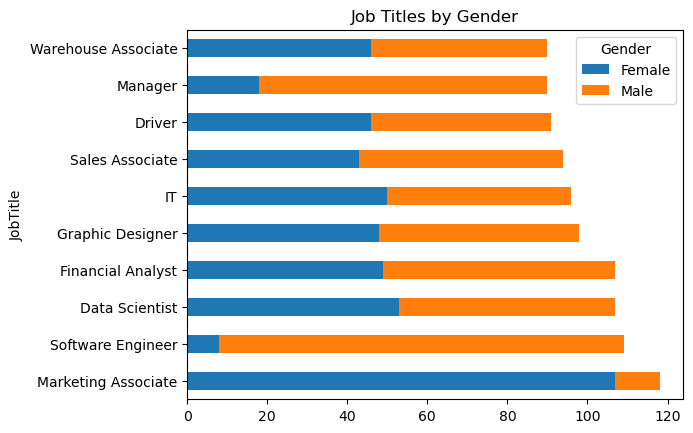

In [26]:
ct = data.groupby(['JobTitle', 'Gender']).size().unstack(fill_value=0)
order = data.value_counts('JobTitle').index
ct = ct.loc[order]
ct.plot(kind='barh', stacked=True)
plt.title('Job Titles by Gender')

Text(0, 0.5, 'Count')

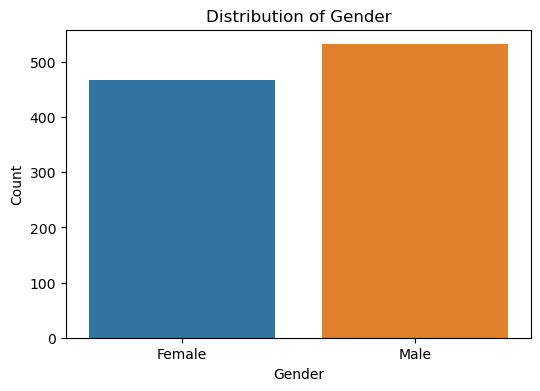

In [20]:
# Gender distribution
plt.figure(figsize=(6, 4))
sns.countplot(data, x='Gender', hue='Gender', legend=False)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

---
## Step 2 | Data Preparation

We prepare the data for analysis by creating new variables.

In [28]:
# Create log of BasePay and binary MALE indicator
data['LogBasePay'] = np.log(data['BasePay'])
data['MALE'] = data['Gender'].map({'Female': 0, 'Male': 1})
data.head()

,JobTitle,Gender,Age,PerfEval,Education,Dept,Seniority,BasePay,Bonus,LogBasePay,MALE
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938,10.654031,0
1,Software Engineer,Male,21,5,College,Management,5,108476,11128,11.594284,1
2,Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268,11.409873,0
3,Software Engineer,Male,20,5,Masters,Sales,4,108080,10154,11.590627,1
4,Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319,11.507551,1


---
## Step 3 | Visualization

We visualize the key relationships in the data.

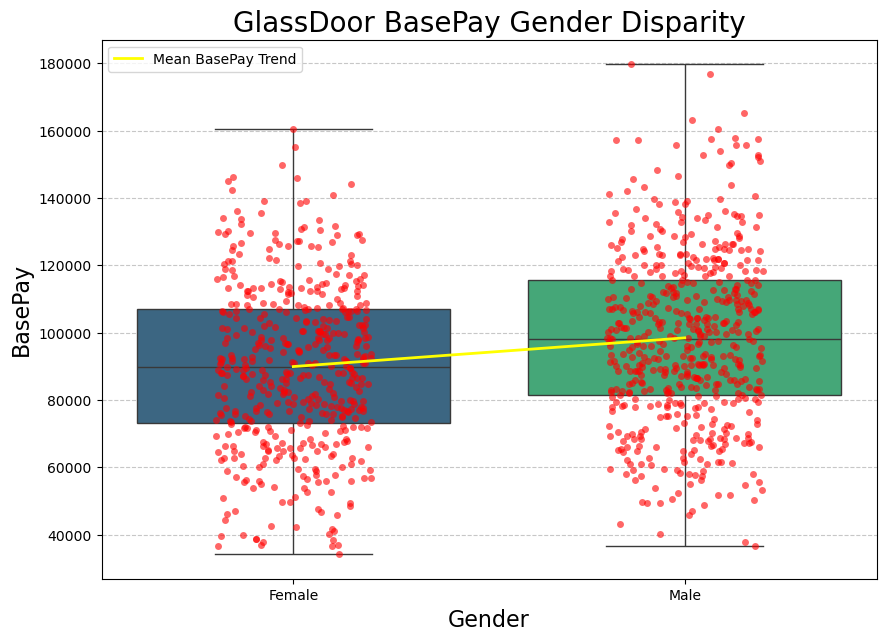

In [31]:
# Whole population: BasePay by Gender
mean_basepay_by_gender = data.groupby('MALE')['BasePay'].mean()
plt.figure(figsize=(10, 7))

sns.boxplot(x='Gender', y='BasePay', data=data, hue='Gender', palette='viridis', legend=False, whis=(0,100))
sns.stripplot(x='Gender', y='BasePay', data=data, color='red', alpha=0.6, jitter=0.2)

plt.plot(mean_basepay_by_gender.index, mean_basepay_by_gender.values,
         color='yellow', linestyle='-', linewidth=2, label='Mean BasePay Trend', zorder=10)

plt.title('GlassDoor BasePay Gender Disparity', fontsize=20)
plt.xlabel('Gender', fontsize=16)
plt.ylabel('BasePay', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

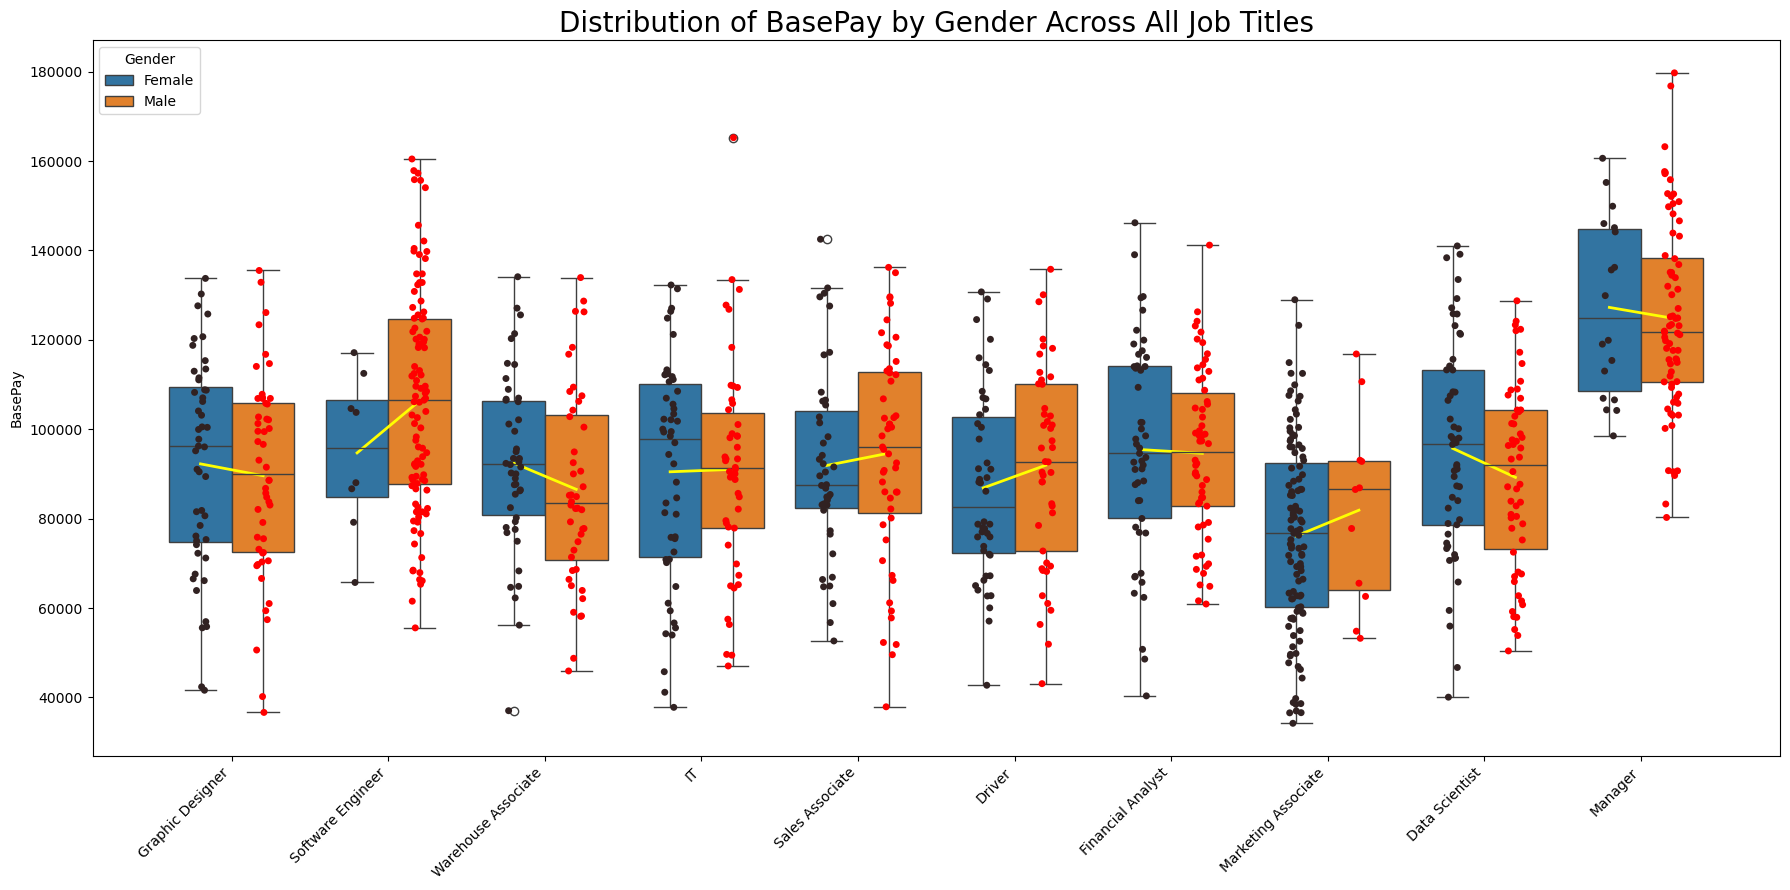

In [48]:
plt.figure(figsize=(18, 9))
                                                                            
sns.boxplot(data, x='JobTitle', y='BasePay', hue='Gender')                                                            
sns.stripplot(data, x='JobTitle', y='BasePay', hue='Gender', palette='dark:red', dodge=True, legend=False)

# Yellow Mean Lines
means = data.groupby(['JobTitle', 'Gender'])['BasePay'].mean().unstack()
for i, job in enumerate(data['JobTitle'].unique()):
    plt.plot([i - 0.2, i + 0.2], [means.loc[job, 'Female'], means.loc[job, 'Male']], color='yellow', linewidth=2)

plt.title('Distribution of BasePay by Gender Across All Job Titles', fontsize=20)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.tight_layout()
plt.show()

---
## Step 4 | Statistical Analysis

We run two regression models to answer the research question:
1. **Uncontrolled Model:** LogBasePay ~ MALE
2. **Controlled Model:** LogBasePay ~ MALE + JobTitle

### Uncontrolled Model

First, we examine the raw gender pay gap without any controls.

In [50]:
model_uncontrolled = smf.ols('LogBasePay ~ MALE', data=data).fit()
model_uncontrolled.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.3665,0.013,867.999,0.000,11.341,11.392
MALE,0.0953,0.018,5.309,0.000,0.060,0.131


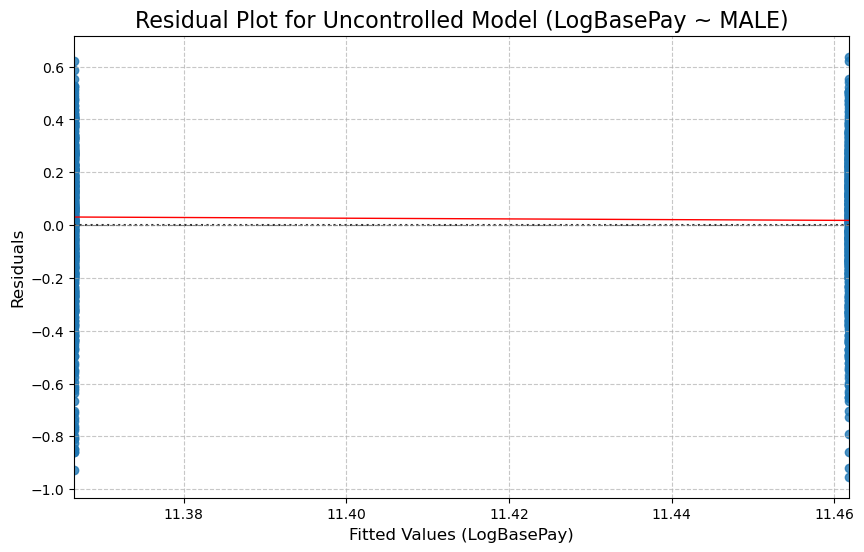

In [51]:
# Residual plot for uncontrolled model
residuals_uncontrolled = model_uncontrolled.resid
fitted_values_uncontrolled = model_uncontrolled.fittedvalues

plt.figure(figsize=(10, 6))
sns.residplot(x=fitted_values_uncontrolled, y=residuals_uncontrolled, lowess=True, 
              line_kws={'color': 'red', 'lw': 1})
plt.title('Residual Plot for Uncontrolled Model (LogBasePay ~ MALE)', fontsize=16)
plt.xlabel('Fitted Values (LogBasePay)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.8)
plt.show()

### Controlled Model

Now we add JobTitle as a categorical control variable.

In [52]:
model_controlled = smf.ols('LogBasePay ~ MALE + JobTitle', data=data).fit()
model_controlled.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.4036,0.027,428.072,0.000,11.351,11.456
JobTitle[T.Driver],-0.0319,0.037,-0.866,0.387,-0.104,0.040
JobTitle[T.Financial Analyst],0.0330,0.035,0.933,0.351,-0.036,0.102
JobTitle[T.Graphic Designer],-0.0205,0.036,-0.568,0.570,-0.092,0.050
JobTitle[T.IT],-0.0260,0.036,-0.716,0.474,-0.097,0.045
JobTitle[T.Manager],0.3234,0.037,8.650,0.000,0.250,0.397
JobTitle[T.Marketing Associate],-0.1988,0.035,-5.627,0.000,-0.268,-0.129
JobTitle[T.Sales Associate],0.0106,0.037,0.291,0.771,-0.061,0.082
JobTitle[T.Software Engineer],0.1382,0.036,3.834,0.000,0.067,0.209
JobTitle[T.Warehouse Associate],-0.0285,0.037,-0.771,0.441,-0.101,0.044


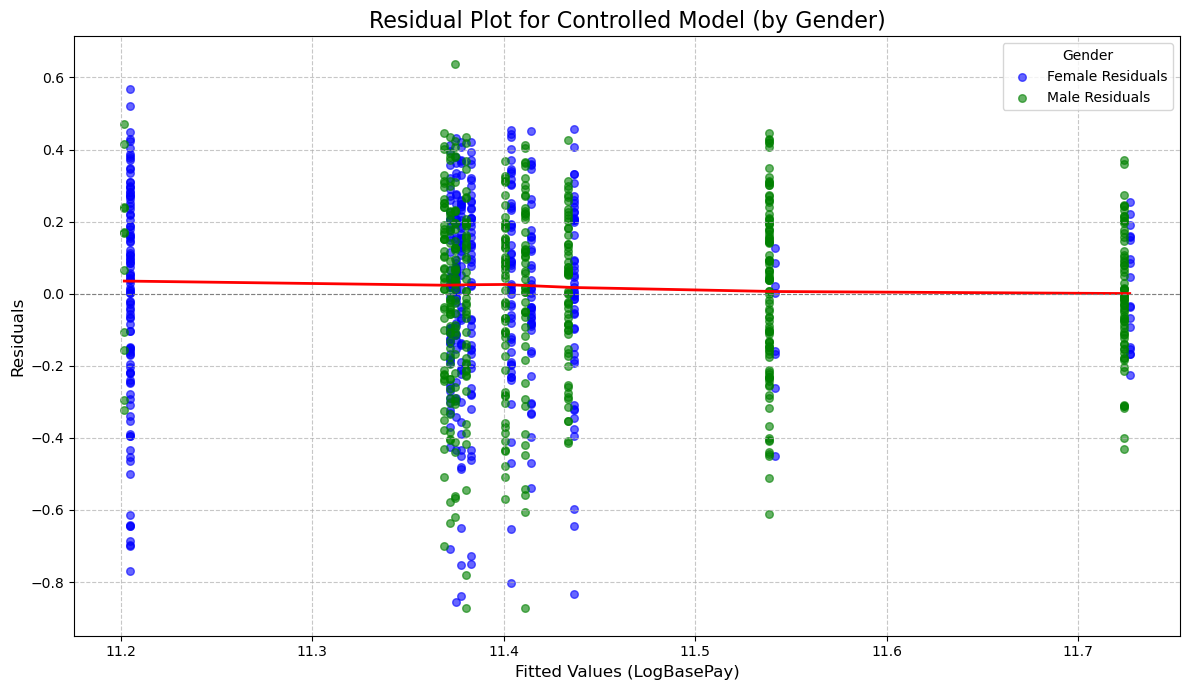

In [53]:
# Residual plot for controlled model
residuals_controlled = model_controlled.resid
fitted_values_controlled = model_controlled.fittedvalues
male_indicator = data['MALE']

# Separate by gender
residuals_female = residuals_controlled[male_indicator == 0]
fitted_values_female = fitted_values_controlled[male_indicator == 0]
residuals_male = residuals_controlled[male_indicator == 1]
fitted_values_male = fitted_values_controlled[male_indicator == 1]

plt.figure(figsize=(12, 7))

jitter_amount_y = 0.005
plt.scatter(fitted_values_female,
            residuals_female + np.random.uniform(-jitter_amount_y, jitter_amount_y, len(residuals_female)),
            alpha=0.6, color='blue', s=30, label='Female Residuals')
plt.scatter(fitted_values_male,
            residuals_male + np.random.uniform(-jitter_amount_y, jitter_amount_y, len(residuals_male)),
            alpha=0.6, color='green', s=30, label='Male Residuals')

sns.regplot(x=fitted_values_controlled, y=residuals_controlled,
            scatter=False, lowess=True, line_kws={'color': 'red', 'lw': 2}, ax=plt.gca())

plt.title('Residual Plot for Controlled Model (by Gender)', fontsize=16)
plt.xlabel('Fitted Values (LogBasePay)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.8)
plt.legend(title='Gender', loc='upper right')
plt.tight_layout()
plt.show()

---
## Step 5 | Results Interpretation

### Key Findings

**Uncontrolled Model (no controls):**
- MALE coefficient: **+0.095** (p < 0.001)
- Interpretation: Males earn approximately 9.5% more than females on average
- This is statistically significant

**Controlled Model (with JobTitle):**
- MALE coefficient: **-0.003** (p = 0.87)
- Interpretation: After controlling for job title, males earn 0.3% *less* than females
- This is **not statistically significant**

### Conclusion

The apparent gender pay gap disappears when we control for job title. This suggests that in this dataset, the pay gap is driven by **occupational sorting** (men and women working in different jobs) rather than **direct pay discrimination** (men and women being paid differently for the same job).

Note: This finding is specific to this Glassdoor dataset and should not be generalized without further research.

---
## Replication Exercises

Try extending this analysis with the following exercises:

### Exercise 1: Add More Controls
Add `Education` and `Seniority` as additional control variables. Does the MALE coefficient change? What does this tell you about other potential sources of the pay gap?

### Exercise 2: Analyze a Specific Job Title
Pick one job title (e.g., Software Engineer or Manager) and run a regression just for that subset. Is there a gender pay gap within that specific occupation?

### Exercise 3: Total Compensation
Create a new variable for total compensation (BasePay + Bonus) and re-run the analysis. Do the results change when including bonuses?

### Challenge Exercise
The dataset shows that Software Engineers are 93% male while Marketing Associates are 91% female. How might this occupational segregation relate to broader questions about the gender pay gap? Write a brief analysis connecting the statistical findings to potential policy implications.

In [ ]:
# Your code for Exercise 1: Add Education and Seniority controls


In [ ]:
# Your code for Exercise 2: Analyze a specific job title


In [ ]:
# Your code for Exercise 3: Total compensation analysis


In [ ]:
# Your code for Challenge Exercise
